In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import wqchartpy
#import datetime
import olm

print("Package versions: ")
print("Matplotlib: ",matplotlib.__version__)
print("NumPy: ", np.__version__)
print("Pandas: ",pd.__version__)
print("WQChartPy: 0.1.10")
#print("datetime
print("olm: 0.39")


Package versions: 
Matplotlib:  3.8.0
NumPy:  1.25.2
Pandas:  1.5.3
WQChartPy: 0.1.10
olm: 0.39


## Read in the MasterWaterQuality.CSV file containing all the data from a weekly samplign field campaign form 2021-2022


Note that this file contains data not used in this analysis. We will only be using the data from Lake Jackson (labeled as "Porter Sink" here), the FSU Well, and Wakulla Springs.

In [16]:
wq_df = pd.read_csv('../data/MasterWaterQuality.csv', parse_dates=['Sampling time'])
wq_df

,ID,Location,Sampling time,dD vs vsmow,d18O vs vsmow,Lithium,Sodium,Ammonium,Potassium,Magnesium,...,Bromide,Nitrate,Phosphate,Sulfate,pH,pOH,Total Alkalinity (mg/L as CaCO3),Bicarbonate,EC(us/cm),color
0,LJ000,Porter Sink,2021-05-04 13:00:00,15.0,3.48,0.0,2.440,0.0,1.077,1.812,...,0.0,0.1223,0.0,0.0,6.52,7.48,13.8,16.836,52.1,k
1,LJ001,Porter Sink,2021-06-07 13:49:00,25.9,6.29,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.11,8.89,2.8,3.416,44.5,k
2,LJ002,Porter Sink,2021-06-08 13:08:00,23.3,5.29,0.0,1.818,0.0,0.949,0.966,...,0.0,0.2130,0.0,0.0,6.55,7.45,6.0,7.320,32.0,k
3,LJ003,Porter Sink,2021-06-14 17:20:00,29.4,6.43,0.0,2.275,0.0,0.733,1.023,...,0.0,0.1929,0.0,0.0,5.99,8.01,7.2,8.784,35.0,k
4,LJ004,Porter Sink,2021-06-21 11:18:00,5.1,3.20,0.0,2.439,0.0,0.778,1.197,...,0.0,0.0000,0.0,0.0,6.31,7.69,9.8,11.956,38.0,k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,PRE001,Rain,2021-06-23 13:50:00,-26.6,-4.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
150,PRE002,Rain,2021-07-05 15:39:00,-50.6,-7.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y
151,PRE003,Rain,2021-07-18 13:15:00,-5.8,-2.93,NaN,NaN,NaN,NaN,NaN,...,0.0,0.2019,0.0,0.0,NaN,NaN,NaN,NaN,NaN,y
152,PRE004,Rain,2021-08-12 17:10:00,4.5,-1.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y


### Use the OLM package from the Covington Lab of University of Arkansas to calculate a more accurate Bicarbonate using the Alkalinity value output from our titrator

In [19]:
###Accurate Bicarbonate Calculation OLM Package and USGS procedure
## ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
from olm.calcite import calc_K_2

#Function to convert Alkalinity as mg/L CaCO3 to meq/L
def alk_mgLCaCo3_to_meqL(alk_mgL):
    alk_meqL=alk_mgL/(1/2)/(100.087)
    return alk_meqL

## Second dissociation constant needed for speciation
K2=calc_K_2(298.15)

# ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
## The calculations mostly use meq/l but they are reconverted to mg/L as an output to keep untis consistent in the dataframe

wq_df['H']=(10**-wq_df['pH'])*1.00784*1000
wq_df["OH"]=(1E-14*(10**wq_df["pH"])*17007.3)
wq_df["CO3"]=(((alk_mgLCaCo3_to_meqL(wq_df["Total Alkalinity (mg/L as CaCO3)"])/1000)-(wq_df['OH']/17007.3)+10**-wq_df['pH'])/(2+(10**-wq_df['pH']/K2)))*60009.2

wq_df["HCO3"]=(((alk_mgLCaCo3_to_meqL(wq_df["Total Alkalinity (mg/L as CaCO3)"])/1000)-(wq_df['OH']/17007.3)+10**-wq_df['pH'])/(1+(2*K2*10**wq_df['pH'])))*61017.1



In [22]:
### Creating a df with special formatting to make it compatible with WQChartPy
format_df = pd.DataFrame()

format_df['Sample'] = wq_df['ID']
format_df['Label'] = wq_df['Location']
format_df['Color']=wq_df['color']
format_df['Marker']='o'
format_df.loc[format_df['Label']== "FSU Well", 'Marker'] = 's'
format_df.loc[format_df['Label']== "Wakulla Springs", 'Color'] = 'b'
format_df['Size']=30
format_df['Alpha']=0.9
format_df['pH'] = wq_df['pH']
format_df['Ca'] = wq_df['Calcium']
format_df['Mg'] = wq_df['Magnesium']
format_df['Na'] = wq_df['Sodium']              
format_df['K'] = wq_df['Potassium']   
format_df['HCO3'] = wq_df['HCO3']
format_df['Cl'] = wq_df['Chloride']
format_df['CO3']=0
format_df['SO4'] = wq_df['Sulfate'].values
format_df['TDS'] = wq_df['EC(us/cm)']*0.7
#format_df['Day']= wq_df['Sampling time'].dt.dayofyear-124
format_df['Label']=format_df["Label"].str.replace("Porter Sink", "Lake Jackson")

format_df=format_df.dropna()
format_df.reset_index(drop=True, inplace=True)
format_df



,Sample,Label,Color,Marker,Size,Alpha,pH,Ca,Mg,Na,K,HCO3,Cl,CO3,SO4,TDS
0,LJ000,Lake Jackson,k,o,30,0.9,6.520,3.560,1.812,2.440,1.077,16.837258,5.9191,0,0.0000,36.47
1,LJ002,Lake Jackson,k,o,30,0.9,6.550,2.393,0.966,1.818,0.949,7.328281,4.6700,0,0.0000,22.40
2,LJ003,Lake Jackson,k,o,30,0.9,5.990,2.460,1.023,2.275,0.733,8.839857,3.8784,0,0.0000,24.50
3,LJ004,Lake Jackson,k,o,30,0.9,6.310,2.656,1.197,2.439,0.778,11.975302,3.8762,0,0.0000,26.60
4,LJ005,Lake Jackson,k,o,30,0.9,6.120,3.499,1.543,4.056,2.849,13.333999,5.0591,0,0.0000,41.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,WS021,Wakulla Springs,b,o,30,0.9,7.490,46.775,9.562,5.250,0.627,166.663498,3.7756,0,6.2653,213.50
72,WS022,Wakulla Springs,b,o,30,0.9,7.370,43.847,9.294,5.086,0.550,159.363739,7.1763,0,9.9069,205.10
73,WS023,Wakulla Springs,b,o,30,0.9,7.980,45.501,9.189,5.141,0.558,166.226529,7.2922,0,10.7847,209.30
74,WS024,Wakulla Springs,b,o,30,0.9,7.485,44.493,9.435,4.705,0.642,161.198161,6.0072,0,8.0690,203.70


# Plotting Timesereis of Individual Ions

Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



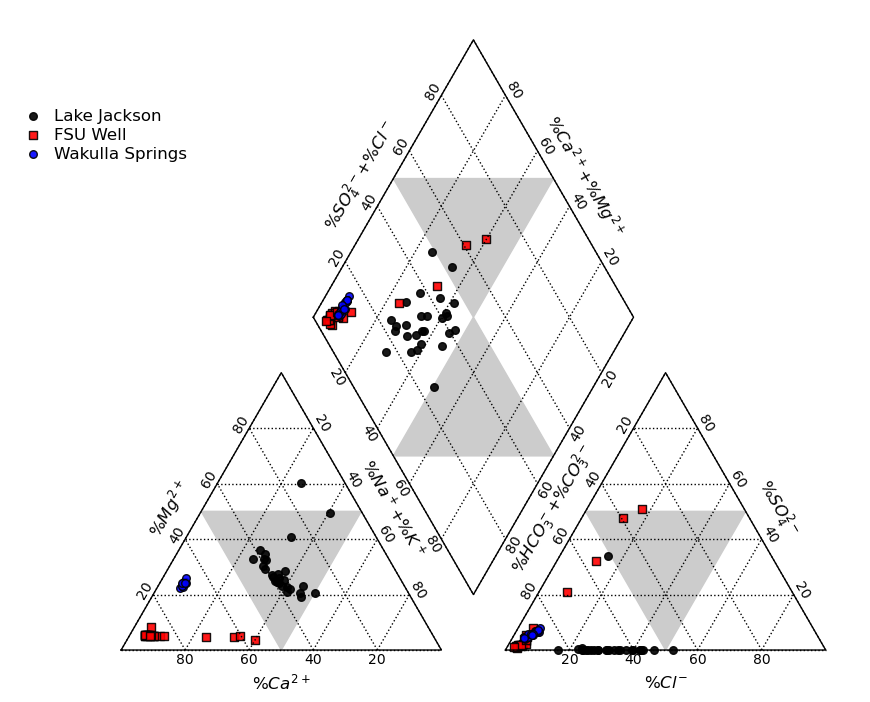

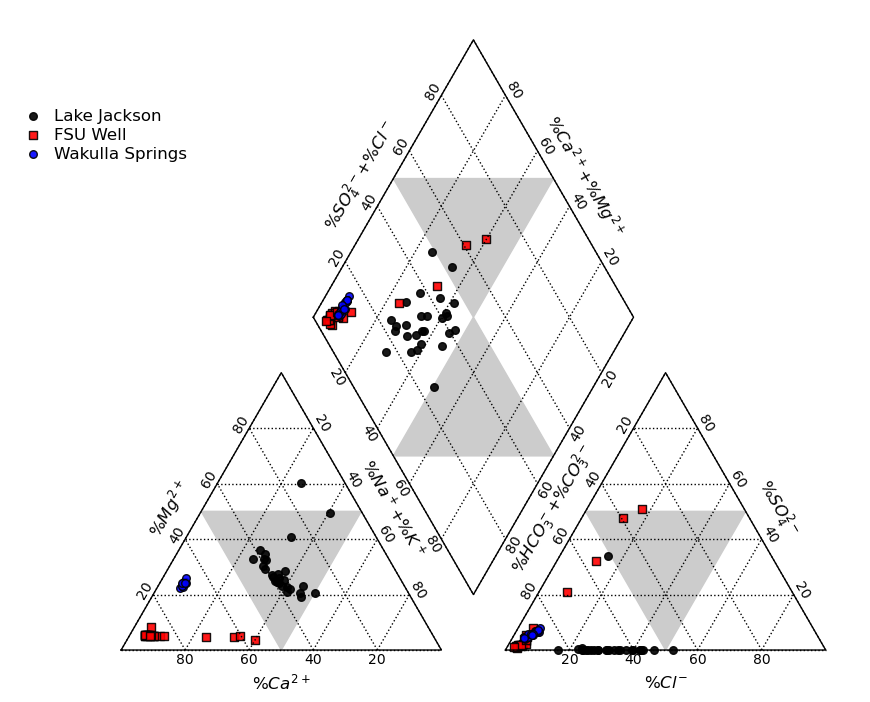

In [23]:
from wqchartpy import triangle_piper

# Draw the diagram and save it to the plots folder in both SVG and jpg formats
triangle_piper.plot(format_df, unit='mg/L', figname='../plots/WeeklyPiper', figformat='jpg')
triangle_piper.plot(format_df, unit='mg/L', figname='../plots/WeeklyPiper', figformat='svg')

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



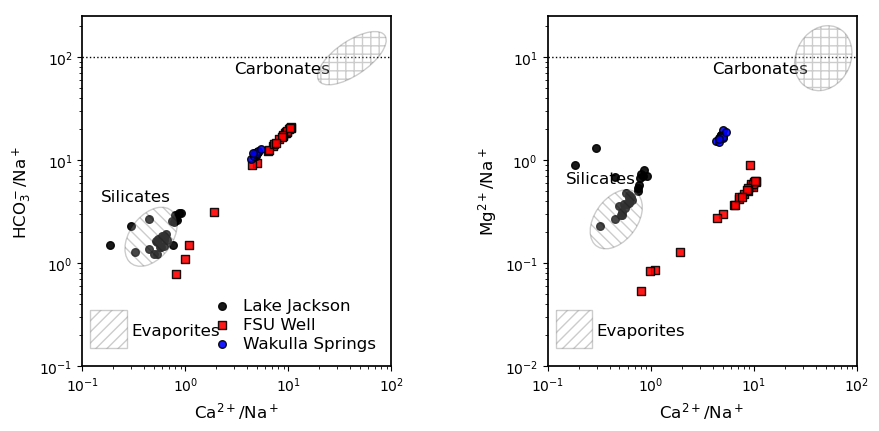

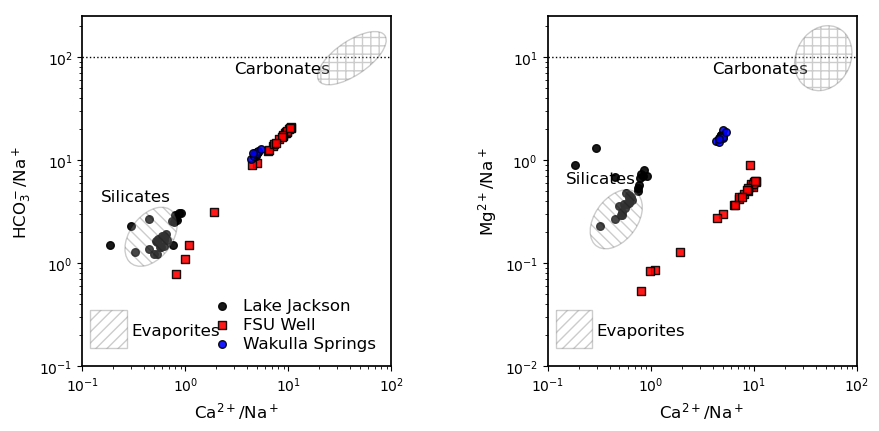

In [24]:
from wqchartpy import gaillardet; 

gaillardet.plot(format_df, unit='mg/L', figname='../plots/WeeklyGaillardet', figformat='jpg')
gaillardet.plot(format_df, unit='mg/L', figname='../plots/WeeklyGaillardet', figformat='svg')

## Read in the Daily scale sampling data that was collected in February 2022

In [26]:
###Daily Scale
FWD = pd.read_csv('../data/FSUWell_FebMar_WQ.csv', parse_dates=['Datatime_Collection'])
FWD

,ID,Datatime_Collection,Li,Na,NH4,K,Mg,Ca,F,Cl,...,NO3,PO4,SO4,EC,TDS,pH,pOH,TotalAlk(mg/L_asCaCO3),Fe,Temp
0,FW100A,NaT,0,20.554,1.313,4.8590,2.124,30.762,1.3080,9.3182,...,8.1533,1.4925,45.2252,213.0,149.10,6.93,7.07,29.2,NaN,22.0
1,FW100B,NaT,0,19.351,1.190,4.4000,2.291,38.636,1.2288,9.0458,...,7.3998,1.4578,41.8836,232.0,162.40,7.33,6.67,46.2,NaN,22.0
2,FW100C,NaT,0,23.277,1.383,5.4860,2.216,34.128,1.3143,10.5550,...,9.6716,1.5028,52.6810,205.0,143.50,7.19,6.81,27.5,NaN,21.9
3,FW101,2022-02-03 17:20:00,0,19.929,1.255,5.3470,1.940,28.456,1.4120,8.7430,...,8.1602,1.2894,44.4687,201.0,140.70,6.83,7.17,23.6,0.220,20.5
4,FW102,2022-02-04 10:45:00,0,20.288,1.197,5.1000,2.117,32.874,1.5083,9.1747,...,8.1795,1.5216,44.7318,211.0,147.70,7.13,6.87,30.1,0.090,19.7
5,FW103,2022-02-05 12:10:00,0,17.335,0.894,4.1830,2.651,49.071,1.2057,9.1106,...,6.2254,1.2443,33.5713,252.0,176.40,8.21,5.79,67.5,0.087,20.7
6,FW104,2022-02-06 18:40:00,0,11.149,0.454,2.4660,3.369,66.684,0.6093,6.7956,...,3.9636,0.8244,19.0000,294.0,205.80,7.72,6.28,115.2,0.330,21.9
7,FW105,2022-02-07 13:40:00,0,7.909,0.209,1.4090,4.350,90.422,0.3530,6.1536,...,2.3276,0.5909,8.9506,298.0,208.60,7.64,6.36,135.8,0.000,21.3
8,FW106,2022-02-08 11:40:00,0,6.577,0.103,1.8280,4.240,85.823,0.3840,5.5829,...,1.5865,0.4624,4.7882,319.0,223.30,7.62,6.38,152.2,0.000,21.1
9,FW107,2022-02-09 16:00:00,0,6.049,0.156,0.1325,3.903,77.680,0.3223,5.2780,...,1.6294,0.4524,5.2684,308.0,215.60,7.71,6.29,143.8,0.163,21.9


In [27]:
###Accurate Bicarbonate Calculation OLM Package and USGS procedure
## ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
from olm.calcite import calc_K_2

def alk_mgLCaCo3_to_meqL(alk_mgL):
    alk_meqL=alk_mgL/(1/2)/(100.087)
    return alk_meqL

## Second dissociation constant needed for speciation
K2=calc_K_2(298.15)

# ALL IN MG/L FROM USGS SOURCE https://or.water.usgs.gov/alk/methods.html#advanced
FWD['H']=(10**-FWD['pH'])*1.00784*1000
FWD["OH"]=(1E-14*(10**FWD["pH"])*17007.3)
FWD["CO3"]=(((alk_mgLCaCo3_to_meqL(FWD["TotalAlk(mg/L_asCaCO3)"])/1000)-(FWD['OH']/17007.3)+10**-FWD['pH'])/(2+(10**-FWD['pH']/K2)))*60009.2

FWD["HCO3"]=(((alk_mgLCaCo3_to_meqL(FWD["TotalAlk(mg/L_asCaCO3)"])/1000)-(FWD['OH']/17007.3)+10**-FWD['pH'])/(1+(2*K2*10**FWD['pH'])))*61017.1

In [28]:
format_df2 = pd.DataFrame()

format_df2['Sample'] = FWD['ID']
format_df2['Label'] = 'Daily FSU Well'
format_df2['Color']='r'
format_df2['Marker']='s'
format_df2['Size']=30
format_df2['Alpha']=0.9
format_df2['pH'] = FWD['pH']
format_df2['Ca'] = FWD['Ca']
format_df2['Mg'] = FWD['Mg']
format_df2['Na'] = FWD['Na']              
format_df2['K'] = FWD['K']   
format_df2['HCO3'] = FWD['HCO3']
format_df2['Cl'] = FWD['Cl']
format_df2['CO3']=0
format_df2['SO4'] = FWD['SO4'].values
format_df2['TDS'] = FWD['EC']*0.7
#format_df['Day']= wq_df['Sampling time'].dt.dayofyear-124
format_df2
format_df2.drop(format_df2.tail(3).index,inplace=True) # drop last n rows


Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Trilinear Piper plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



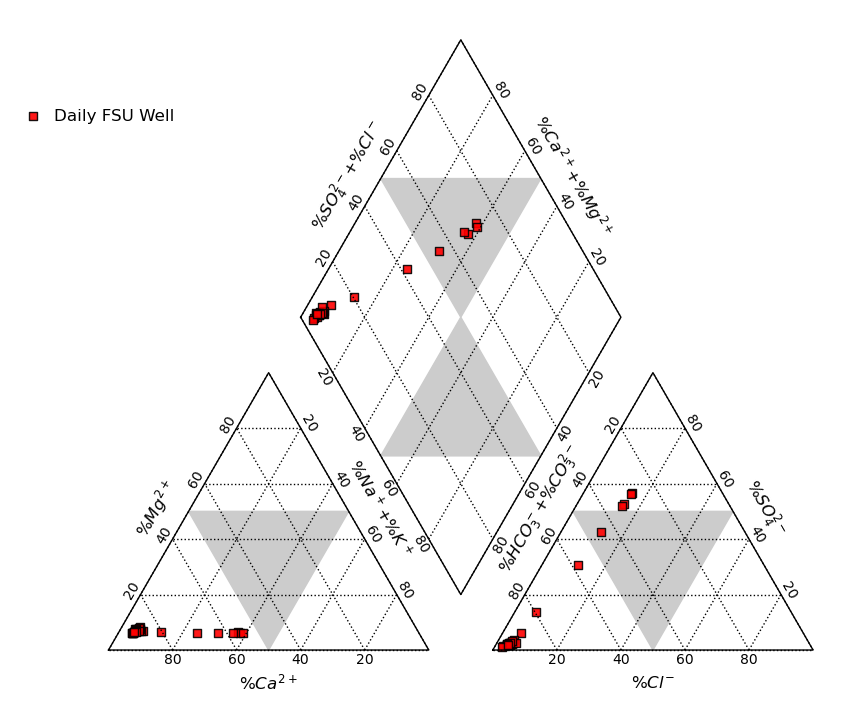

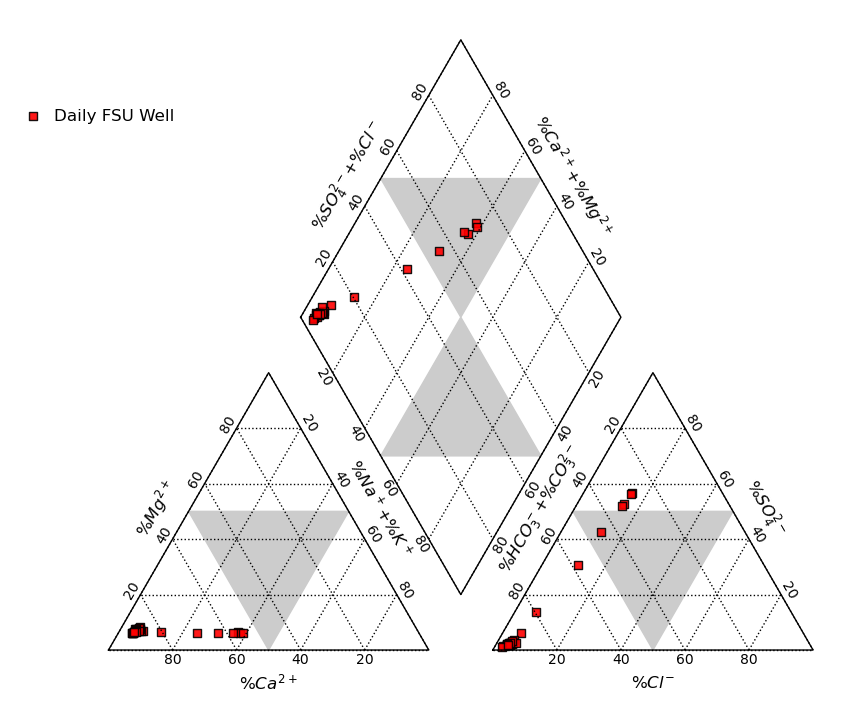

In [30]:
from wqchartpy import triangle_piper

# Draw the diagram
triangle_piper.plot(format_df2, unit='mg/L', figname='../plots/PiperDaily', figformat='jpg')
triangle_piper.plot(format_df2, unit='mg/L', figname='../plots/PiperDaily', figformat='SVG')

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 

Gaillardet plot created. Saving it to C:\Users\kylec\OneDrive - Florida State University\Documents\PhD\Research\Hydrochemcial_SinkholeDryDown\code 



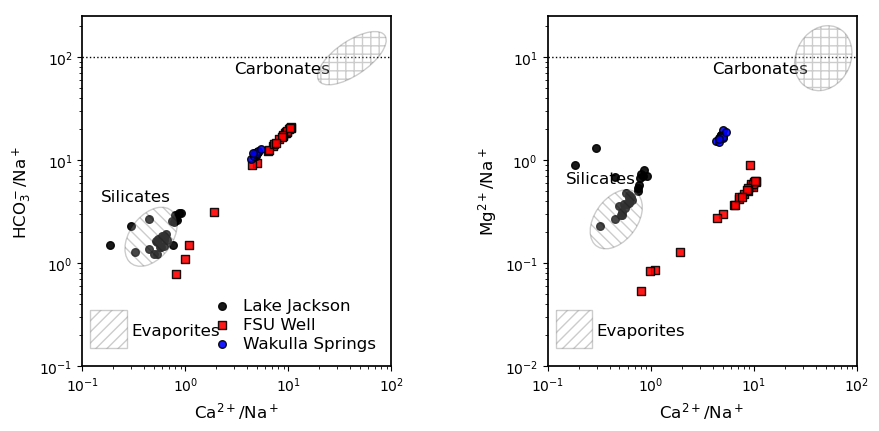

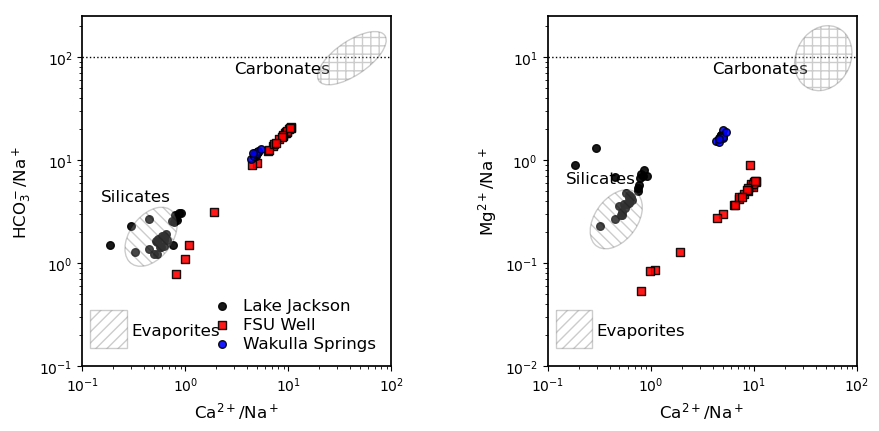

In [31]:
from wqchartpy import gaillardet;
gaillardet.plot(format_df, unit='mg/L', figname='../plots/GaillardetDaily', figformat='svg')
gaillardet.plot(format_df, unit='mg/L', figname='../plots/GaillardetDaily', figformat='jpg')

In [ ]:
### PLOT TIMESERIES OF INDIVIDUAL IONS AT DAILY SCALE